## Das Jahr der Unruhe - Feinjustage der Visualisierung

am 25.2.2020 wurde die erste Coronainfektion in der Schweiz nachgewiesen. Seither hat das Virus nicht nur die Infizierten im Griff, sondern sich tief in unser Leben gefressen. Das lässt sich auch daran ablesen, dass auf der Startseite der NZZ nur  wenige Themen gegen den (facettenreichen) Corona-Reigen eine Chance hatten: Lockdown und Schliessungen, ausfallende Sport- und Kulturveranstaltungen, finanzielle und psychische Belastung, die Toten, Testen und Tracen, Impfstoffe. 

Wie viel Raum diese Themen in den letzten 12 Monaten auf der Frontpage der NZZ hatten, zeichne ich in einer Visualisierung nach. 

**1. Stemmer installieren**

In [179]:
import pandas as pd
from nltk.stem.cistem import Cistem
stemmer = Cistem()

In [180]:
# Stemmer-Anwendung ausprobieren:
lst_Tests = ['Massentests', 'Rückverfolgung', 'Testcenter', 'contact tracing', 'PCR', 'Schnelltest']
lst_stemmed = []
for word in lst_Tests:
    word_stemmed = stemmer.stem(word)
    lst_stemmed.append(word_stemmed)
lst_stemmed

['massentest',
 'ruckverfolgung',
 'testcent',
 'contact tracing',
 'pcr',
 'schnelltest']

In [181]:
# Später müssen wir ganze Sätze stemmen mit removal von Stopwords, Satzzeichen und Zahlen.
# Dies geht so:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

string = 'Trumps Kampagne des maximalen Drucks gegen Iran ist gescheitert, nun braucht Amerika eine neue Strategie. Joe Biden sollte die verfehlte Iran-Politik seines Vorgängers korrigieren und rasch zum Atomabkommen zurückkehren. Erst dann gibt es die Chance, mit Teheran über eine Verlängerung des Abkommens und andere Streitfragen ins Gespräch zu kommen.'

tokens = nltk.word_tokenize(string)
stemmed = [stemmer.stem(w) for w in tokens if w not in stopwords.words('german') and w.isalpha()] 

**2. Daten bereinigen, Stemming von Titel und Teaser**

Nach dem Scraping liegen über 7000 csvs vor, die ich in eines zusammengeführt habe.

In [182]:
from nltk.corpus import stopwords
stopset = stopwords.words('german')
stopset.append('Nan')

In [183]:
def stemtitle(a, b):
    string = str(a) + ' ' + str(b)
    tokens = nltk.word_tokenize(string)
    stemmed = [stemmer.stem(w) for w in tokens if w not in stopset and w.isalpha()]
    s = ' '
    return s.join(stemmed)                           # gibt anstelle Liste einen String aus > besser für Suche

In [184]:
data = pd.read_csv('frontpage_complete.csv').fillna(value='')    # Entfernt NaNs vor dem Anwenden der Funktion

data['stemmed'] = data.apply(lambda row : stemtitle(row['Titel'], row['Teaser']), axis = 1) 
data['date'] = pd.to_datetime(data['timestamp'], format='%Y%m%d%H%M%S') # Konversion timestamp > Zeitformat
data.head()

,Unnamed: 0,Titel,Teaser,url,timestamp,stemmed,date
0,0,2019 war ein Jahr der Proteste. Eine...,"Ob in Chile, Hongkong, Frankreich, Liban...",www.nzz.ch/international/jahr-der-proteste-war...,20200101001752,jahr protest eine meinsam ideologie steck dahi...,2020-01-01 00:17:52
1,1,"Von Chile bis Hongkong, von Januar b...","Millionen demonstrieren, Langzeitpräside...",www.nzz.ch/international/zehn-herausragende-er...,20200101001752,von chil hongkong januar dezemb herausrag erei...,2020-01-01 00:17:52
2,2,Der Beat der Proteste: Diese Musiker...,Die Chilenin Mon Laferte hat sich mit ih...,www.nzz.ch/feuilleton/lateinamerika-neue-prote...,20200101001752,der beat protest dies musik stell lateinamerik...,2020-01-01 00:17:52
3,3,"Feinstaub, Böllerverbote und das Feu...",In Zürich werden an Silvester wieder übe...,www.nzz.ch/zuerich/zuerich-silvesterzauber-das...,20200101001752,feinstaub bollerverbot feuerwerk zeit klimastr...,2020-01-01 00:17:52
4,4,"«Ich weiss, wer den besten Käse hat»...",,www.nzz.ch/schweiz/neujahrsansprachen-ich-weis...,20200101001752,ich weiss wer bes kas diskr charm prasidential...,2020-01-01 00:17:52


**3. Daten-Exploration und Visualisierung**

In [254]:
# Steamplot für multiple Suchanfragen
import matplotlib.pyplot as plt
import re

def steamplot(lst):
    mydata = data[['stemmed', 'date']].copy()
    for wort in lst:
        print(f"Looking at {wort}")
        mydata[wort] = mydata['stemmed'].str.contains(wort, flags=re.IGNORECASE).astype(int) 
    # resample
    dtrends = mydata.resample('8D', on='date').mean()
    # smooth
    first = dtrends.index.min()
    last = dtrends.index.max()
    frequency = pd.date_range(start=first, end=last, freq='2D')
    dsmooth = dtrends.reindex(frequency).interpolate(method='quadratic')
    # display
    fig, ax = plt.subplots(figsize=(15,5))
    ax.stackplot(dsmooth.index, dsmooth.T, baseline='wiggle', labels=dsmooth.columns)  
    ax.legend(loc=(1.04,0))

Looking at corona*
Looking at trump


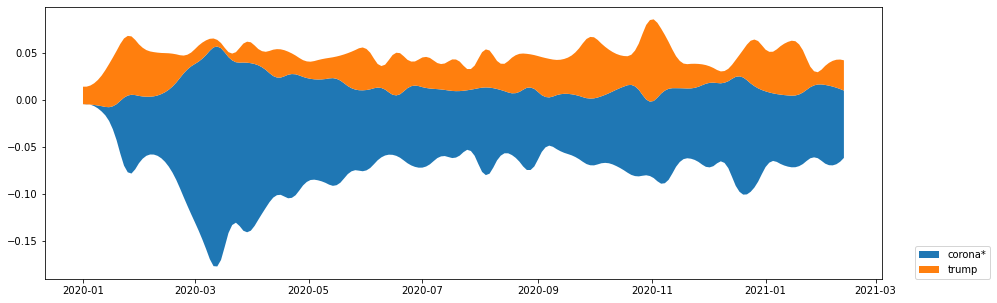

In [241]:
lst = ['corona*', 'trump']
steamplot(lst)
plt.savefig('trends1.svg', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')
plt.savefig('trends1.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')

Looking at krise*
Looking at impf*
Looking at massnahm*
Looking at pandemie
Looking at trump


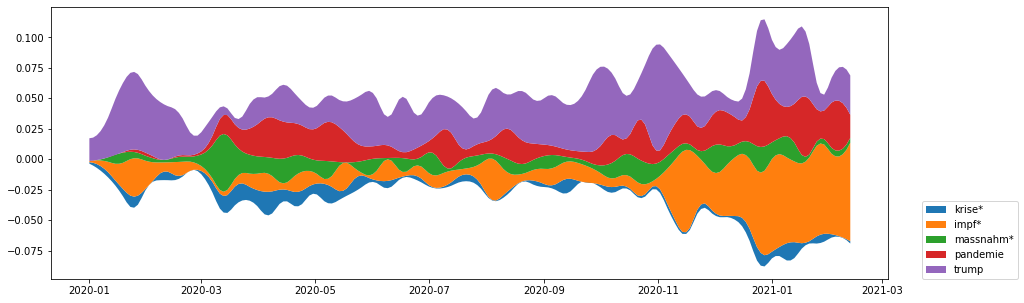

In [242]:
lst = ['krise*', 'impf*', 'massnahm*', 'pandemie', 'trump']
steamplot(lst)
plt.savefig('trends2.svg', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')
plt.savefig('trends2.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')

Looking at maske*
Looking at homeschooling
Looking at party
Looking at zoom
Looking at lockdown


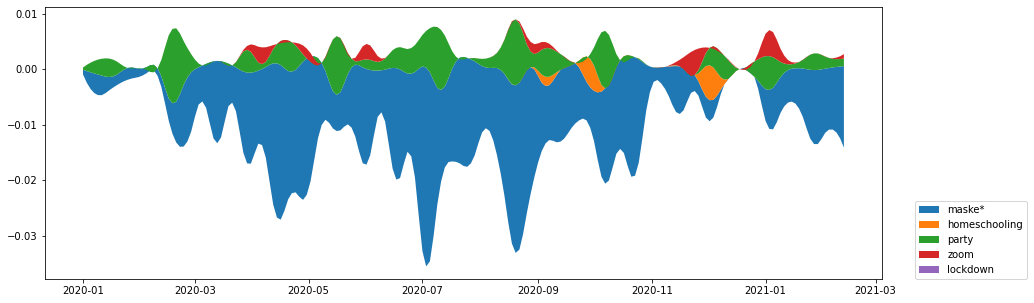

In [243]:
lst = ['maske*', 'homeschooling', 'party', 'zoom', 'lockdown']
steamplot(lst)
plt.savefig('trends3.svg', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')
plt.savefig('trends3.pdf', dpi=None, facecolor='w', edgecolor='w',
        orientation='landscape')

**4. Kategorien und Suchworte optimieren: Mein Dataviz-Sandkasten**

Wir wollen die grosse Visualisierung mit Annotationen versehen, idealerweise so, dass auch gleich anklickbare Headlines herauskommen. Dazu möchte ich jede Suchkategorie einzeln darstellen und die Maxima aufsuchen. Dann in einem Zeitraum +- 3 Tage vom Maximum (alle) Headlines die das Suchwort enthalten anzeigen und zusammen mit der URL abspeichern.

Für die Exploration können wir mit der Steamplot-Funktion von oben arbeiten (vereinfachen ihn aber: wir nehmen die wiggle-Baseline raus, ebenso das smoothing, damit man die Ergebnisse besser sieht ;) ).

In [255]:
def simpleplot(lst):
    mydata = data[['Titel', 'url', 'stemmed', 'date']].copy()
    for wort in lst:
        print(f"Looking at {wort}")
        mydata[wort] = mydata['stemmed'].str.contains(wort, flags=re.IGNORECASE).astype(int) 
    # resample
    dtrends = mydata.resample('8D', on='date').mean()
    # display
    fig, ax = plt.subplots(figsize=(15,5))
    ax.stackplot(dtrends.index, dtrends.T, labels=dtrends.columns)  
    ax.legend(loc=(1.04,0))

In [256]:
lst_krise = ['Coronakri*', 'Corona-Pand*', 'Pandemi']
lst_lockdown = ['lockdow', 'shutdow']
lst_impfen = ['Impfstoff*', 'Impfstoffkandidat*', 'impf*', 'Impfung*']
lst_massnahmen = ['massnahm*', 'Massnahmenkat*', 'Corona-Massnahm*']
lst_quarantaene = ['quarantä*']
lst_hygiene = ['hygien*', 'desinf*', 'abstand']
        
kat_opt = [lst_krise, lst_lockdown, lst_impfen, lst_massnahmen, lst_quarantaene, lst_hygiene]        

Looking at Coronakri*
Looking at Corona-Pand*
Looking at Pandemi
Looking at lockdow
Looking at shutdow
Looking at Impfstoff*
Looking at Impfstoffkandidat*
Looking at impf*
Looking at Impfung*
Looking at massnahm*
Looking at Massnahmenkat*
Looking at Corona-Massnahm*
Looking at quarantä*
Looking at hygien*
Looking at desinf*
Looking at abstand


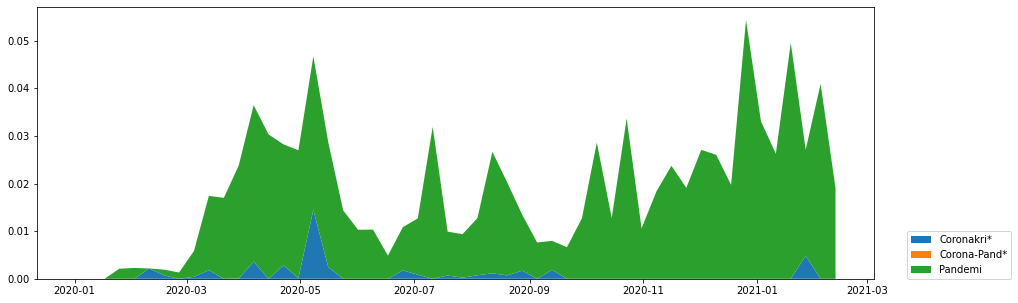

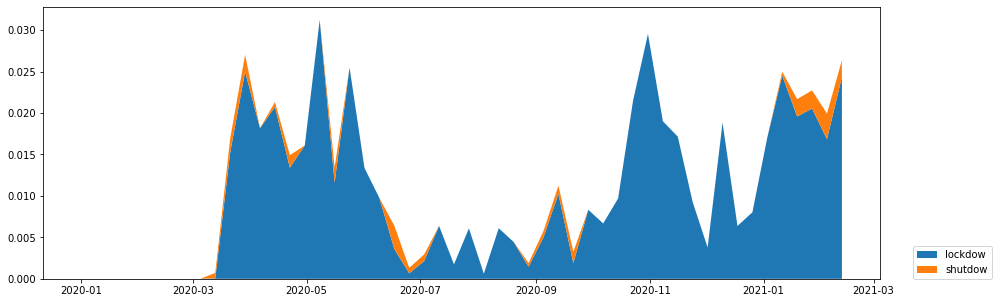

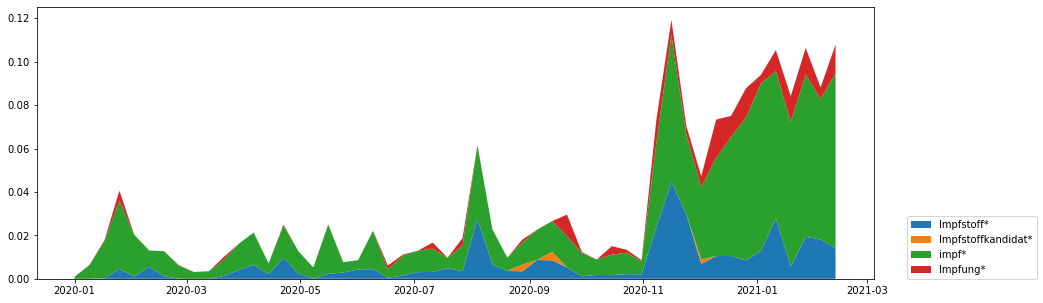

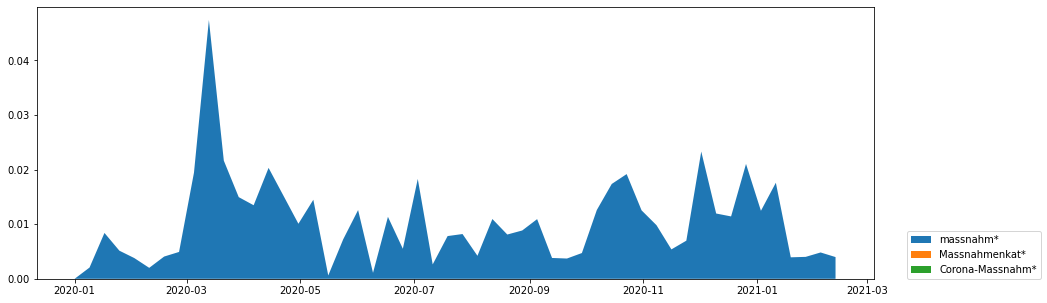

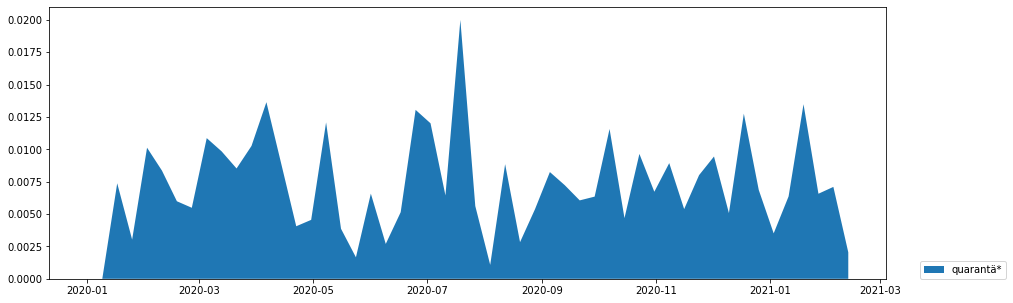

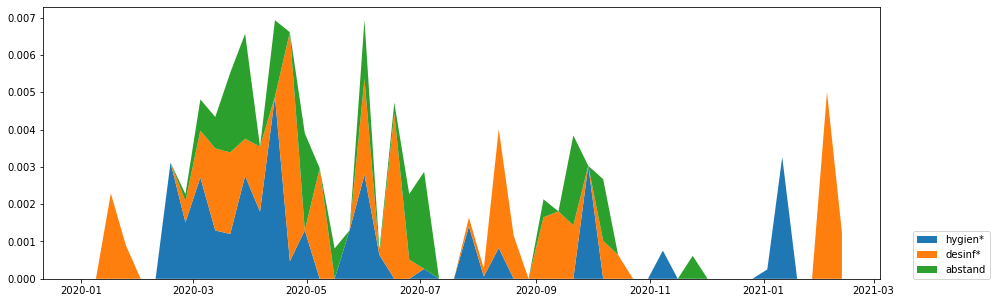

In [260]:
for x in kat_opt:
    simpleplot(x)

In [258]:
lst_mut = ['mutation*', 'mutier*']
lst_wuhan = ['Wuha*', 'Hubei', 'wildtier*']
lst_tot =  ['triag*', 'intensivbett*', 'ubersterblich*', 'intensivstatio*']
lst_aero = ['tröpfch*', 'aerosol*', 'superspread*', 'ischgl']
lst_home = ['homeoffice', 'homeschooling', 'fernunterricht*', 'heimarbeit*', 'videokonferenz*']
lst_maske = ['Maskenpflicht', 'Mask*', 'Mund-Nasen-Schutz', 'schutzmask*', 'gesichtsmask*', 'atemschutzmask*']
lst_testen = ['massentest*', 'ruckverfolg*', 'testcent*', 'contact tracing', 'schnelltest']
    
gruppe2 = [lst_mut, lst_wuhan, lst_tot, lst_aero, lst_home, lst_maske, lst_testen]    

Looking at mutation*
Looking at mutier*
Looking at Wuha*
Looking at Hubei
Looking at wildtier*
Looking at triag*
Looking at intensivbett*
Looking at ubersterblich*
Looking at intensivstatio*
Looking at tröpfch*
Looking at aerosol*
Looking at superspread*
Looking at ischgl
Looking at homeoffice
Looking at homeschooling
Looking at fernunterricht*
Looking at heimarbeit*
Looking at videokonferenz*
Looking at Maskenpflicht
Looking at Mask*
Looking at Mund-Nasen-Schutz
Looking at schutzmask*
Looking at gesichtsmask*
Looking at atemschutzmask*
Looking at massentest*
Looking at ruckverfolg*
Looking at testcent*
Looking at contact tracing
Looking at schnelltest


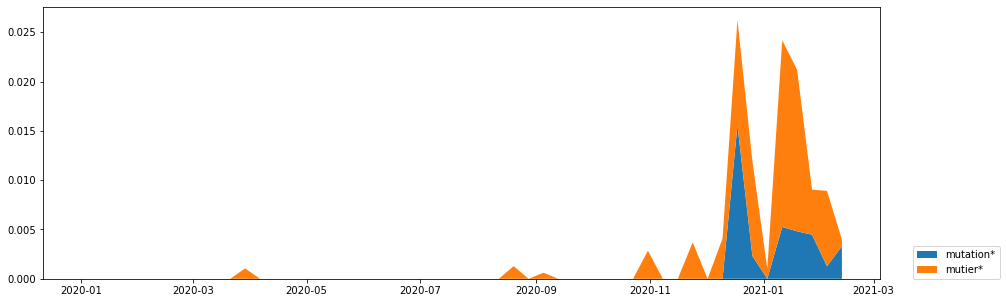

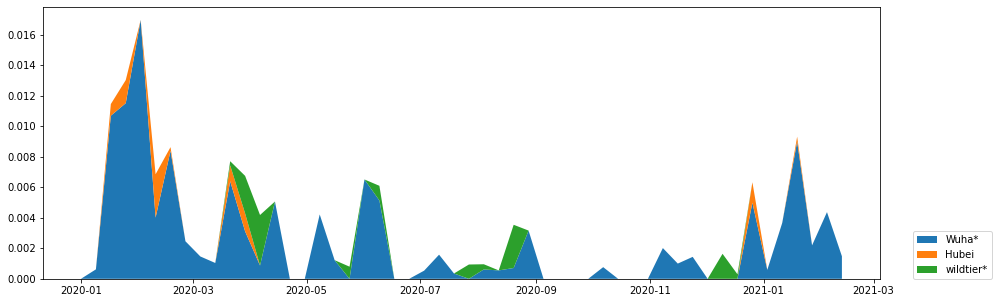

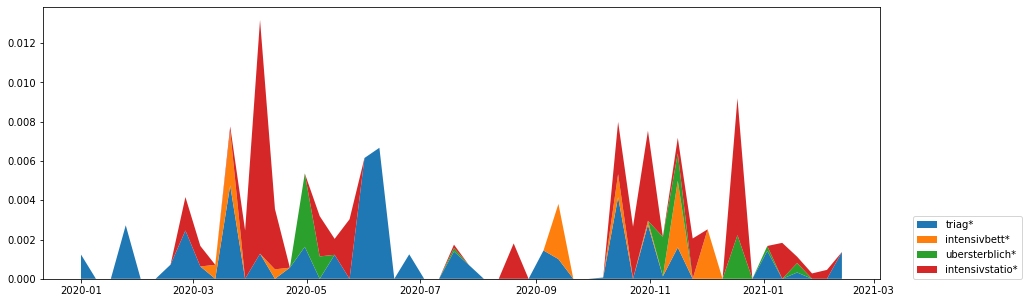

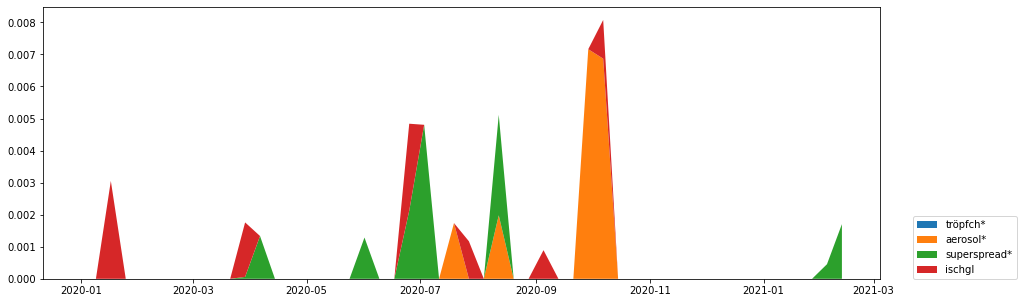

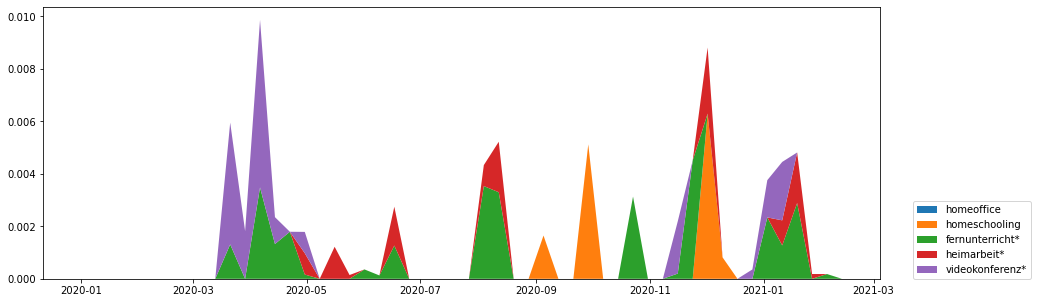

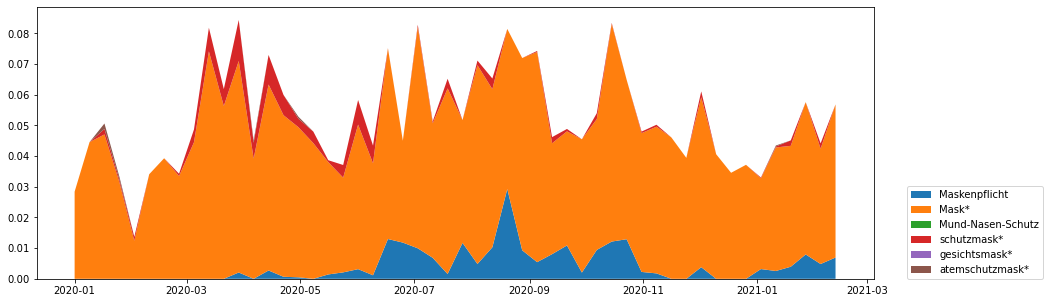

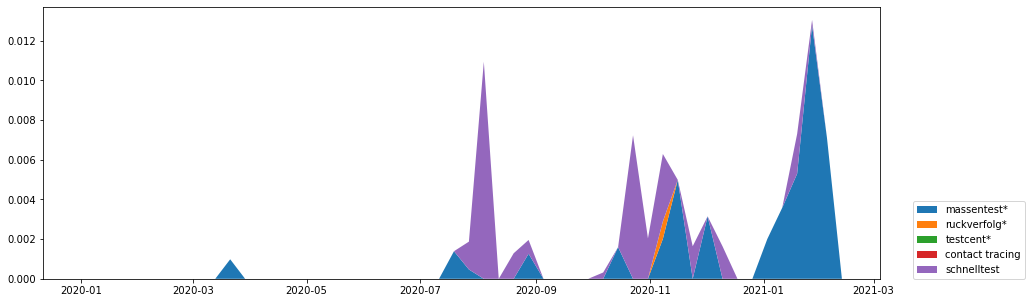

In [261]:
for x in gruppe2:
    simpleplot(x)

In [236]:
lst_corona = ['Corona*', 'Covid*', 'Sars-CoV-2']
lst_risiko = ['risikogrupp*', 'risikopat*', 'voerkrank*']
lst_last = ['uberlast*', 'psych*', 'belast*', 'überlast*', 'einsam*']
lst_skeptiker = ['corona-skept*', 'corona-leug*', 'impfskept*', 'corona-demo*']

gruppe3 = [lst_corona, lst_risiko, lst_last, lst_skeptiker]

Looking at Corona*
Looking at Covid*
Looking at Sars-CoV-2
Looking at risikogrupp*
Looking at risikopat*
Looking at voerkrank*
Looking at uberlast*
Looking at psych*
Looking at belast*
Looking at überlast*
Looking at einsam*
Looking at corona-skept*
Looking at corona-leug*
Looking at impfskept*
Looking at corona-demo*


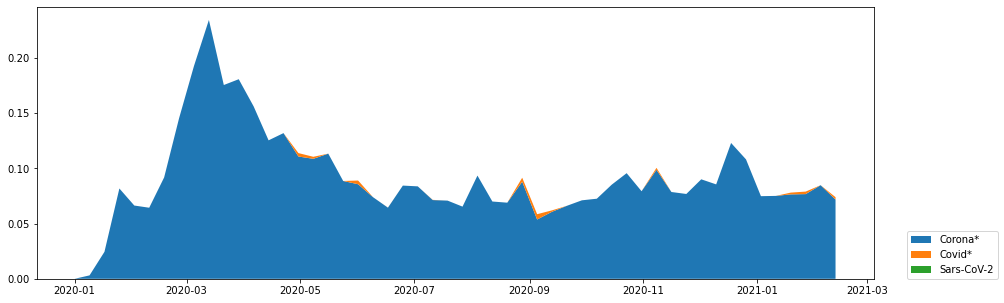

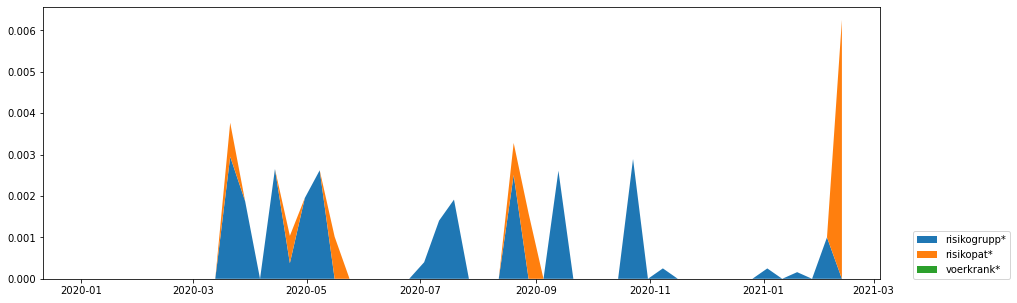

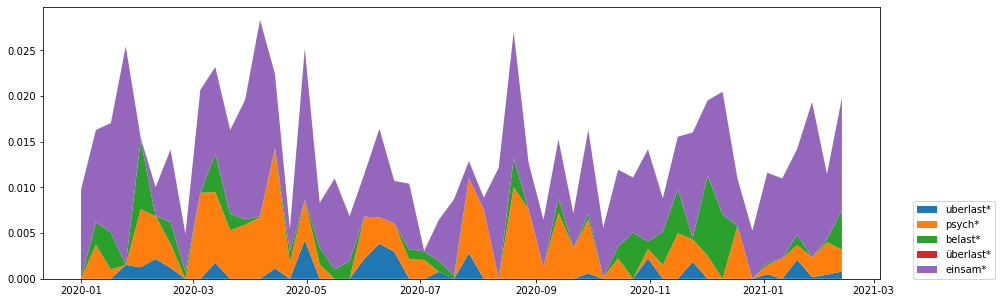

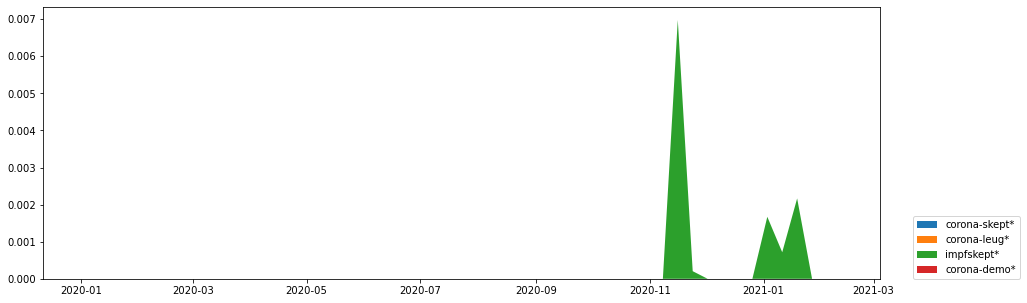

In [263]:
for x in gruppe3:
    simpleplot(x)

Nachdem ich hier durch Ausprobieren sehen konnte, wie gross die Beiträge welcher Suchworte zum Resultat sind, kann ich meine Suchkategorien entsprechend anpassen, die Suchworte neu gruppiern und ggf. zusammenfassen.

**5. Komplexe Suchanfragen mit Suchwort-Kategorien:**

In [273]:
def superplot(search):  # search bezeichnet mehrere Dataframes mit zu Kategorien zugeordneten Suchworten
    # df_set erzegen
    dfs = []
    for key,values in search.items():
        terms = []
        for term in values:                                   
            term_stemmed = stemmer.stem(term)               
            terms.append(term_stemmed)
        words =pd.DataFrame({'category': key, 'term': terms})
        dfs.append(words)
    df_search = pd.concat(dfs)
    
    mydata = data[['stemmed', 'date']].copy()
    for category, rows in df_search.groupby('category'):
        terms = list(rows['term'])
        print(f'Suche nach {category} mit den Schlagworten {terms}')
        mydata[category] = mydata['stemmed'].apply(lambda x: 1 if any(i in x for i in terms) else 0)

    # resample
    ktrends = mydata.resample('8D', on='date').mean()
    # smooth
    first = ktrends.index.min()
    last = ktrends.index.max()
    frequency = pd.date_range(start=first, end=last, freq='2D')
    ksmooth = ktrends.reindex(frequency).interpolate(method='quadratic')
    # display
    fig, ax = plt.subplots(figsize=(15,5))
    ax.stackplot(ksmooth.index, ksmooth.T, labels=ksmooth.columns) #baseline='wiggle', 
    ax.legend(loc=(1.04,0))    
    # plt.savefig(f'{search[0][0]}.pdf', dpi=None, facecolor='w', edgecolor='w',
    #    orientation='landscape')

In [274]:
bigones = {
    'Pandemie': ['Coronakrise', 'Pandemie', 'Corona-Pandemie'],
    'Impfen': ['Impfstoff', 'Impfstoffkandidat', 'impfen', 'Impfung'],
    'Massnahmen': ['Massnahmen', 'Massnahmenkatalog', 'Corona-Massnahmen'],
    'Masken': ['Maskenpflicht', 'Maske', 'Schutzmaske', 'Atemschutzmaske', 'Schutzausrüstung']
}

minors = {
    'Lockdown': ['Lockdown', 'Shutdown'],
    'Testing-Tracing-Quarantaene': ['Quarantäne', 'Massentest', 'Rückverfolgung', 'Testcenter', 'contact tracing', 'Schnelltest'],
    'Mutationen': ['Mutationen', 'mutieren', 'B.1.1.7', 'Viruslinie'],
    'Wuhan': ['Wuhan', 'Hubei', 'Wildtiermarkt'],
    'Intensivbetten': ['Triage', 'Intensivbett', 'Intensivstation', 'Intensivpflege', 'Übersterblichkeit'],
    'Superspreader': ['Aerosole', 'Superspreader', 'Ischgl']
#    'Homeoffice': ['Homeoffice', 'Homeschooling', 'Heimarbeit', 'Fernunterricht', 'Videokonferenz', 'Zoom-Call'],
}

comp = {
    'Corona': ['Corona', 'Covid', 'Sars-CoV-2'],
    'Trump': ['Trump', 'US-Wahl', 'Präsidentschaftswahlen', 'Vorwahlen', 'Wahlmänner']
    
}

searches = [bigones, minors] #, comp]

Suche nach Intensivbetten mit den Schlagworten ['triag', 'intensivbett', 'intensivstatio', 'intensivpfleg', 'ubersterblichkeit']
Suche nach Lockdown mit den Schlagworten ['lockdow', 'shutdow']
Suche nach Mutationen mit den Schlagworten ['mutatio', 'mutier', 'b.1.1.7', 'viruslinie']
Suche nach Superspreader mit den Schlagworten ['aerosol', 'superspread', 'ischgl']
Suche nach Testing-Tracing-Quarantaene mit den Schlagworten ['quaranta', 'massentest', 'ruckverfolgung', 'testcent', 'contact tracing', 'schnelltest']
Suche nach Wuhan mit den Schlagworten ['wuha', 'hubei', 'wildtiermarkt']


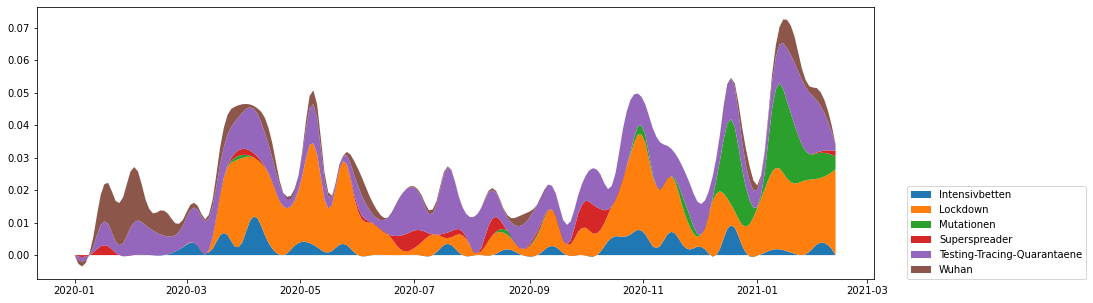

In [275]:
#for x in searches:

superplot(minors)
plt.savefig('minors_v2.svg', dpi=None, facecolor='w', edgecolor='w',
    orientation='landscape')

Suche nach Impfen mit den Schlagworten ['impfstoff', 'impfstoffkandidat', 'impf', 'impfung']
Suche nach Masken mit den Schlagworten ['maskenpflicht', 'mask', 'schutzmask', 'atemschutzmask', 'schutzausrustung']
Suche nach Massnahmen mit den Schlagworten ['massnahm', 'massnahmenkatalog', 'corona-massnahm']
Suche nach Pandemie mit den Schlagworten ['coronakri', 'pandemie', 'corona-pandemie']


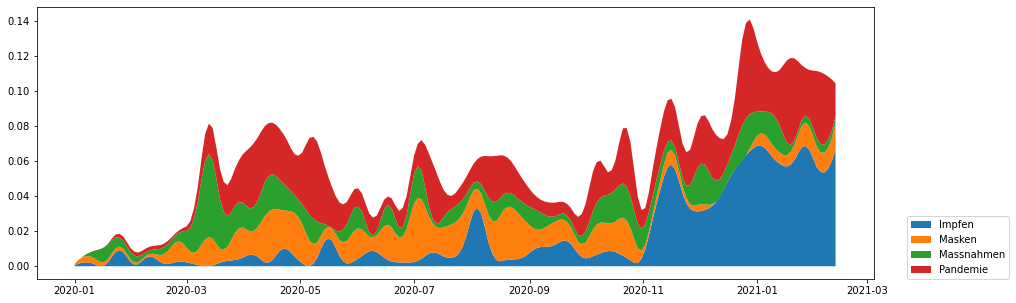

In [276]:
superplot(bigones)
plt.savefig('bigones_v2.svg', dpi=None, facecolor='w', edgecolor='w',
    orientation='landscape')

**6. Headlines extrahieren**

Ich will versuchen, automatisiert zu jeder Suchkategorie das Maximum aufzusuchen und dann in diesem Zeitraum die Headlines auszulesen, die passende Suchworte enthalten.

In [219]:
# Mit den "grossen" Kategorien:

# stemming der Listen:
dfs = []
for key,values in bigones.items():
    terms = []
    for term in values:                                   
        term_stemmed = stemmer.stem(term)               
        terms.append(term_stemmed)
    words =pd.DataFrame({'category': key, 'term': terms})
    dfs.append(words)
df_search = pd.concat(dfs)
    
mydata = data[['stemmed', 'date']].copy()
for category, rows in df_search.groupby('category'):
    terms = list(rows['term'])
    print(f'Suche nach {category} mit den Schlagworten {terms}')
    mydata[category] = mydata['stemmed'].apply(lambda x: 1 if any(i in x for i in terms) else 0)

Suche nach Impfen mit den Schlagworten ['impfstoff', 'impfstoffkandidat', 'impf', 'impfung']
Suche nach Masken mit den Schlagworten ['maskenpflicht', 'mask', 'schutzmask', 'atemschutzmask', 'schutzausrustung']
Suche nach Massnahmen mit den Schlagworten ['massnahm', 'massnahmenkatalog', 'corona-massnahm']
Suche nach Pandemie mit den Schlagworten ['coronakri', 'pandemie', 'corona-pandemie']


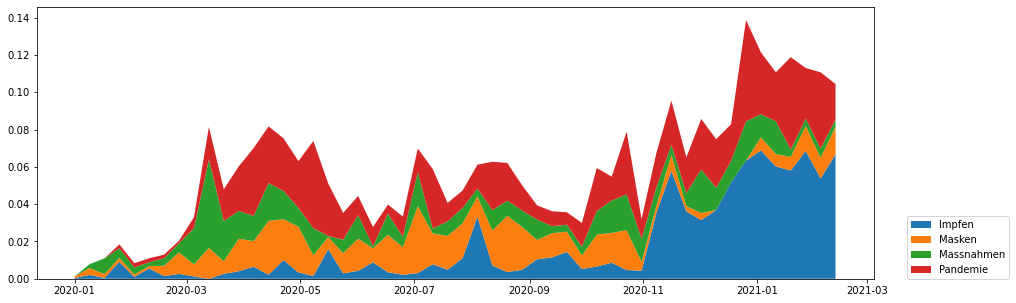

In [220]:
# resample
trends = mydata.resample('8D', on='date').mean()
# plot ohne smoothing und ohne steam:
fig, ax = plt.subplots(figsize=(15,5))
ax.stackplot(trends.index, trends.T, labels=trends.columns)
ax.legend(loc=(1.04,0))   

Jetzt möchte ich von jeder Zeitreihe das Maximum finden, am besten sogar die wichtigsten drei (oder 10?) Maxima

In [221]:
trends.head()

,Impfen,Masken,Massnahmen,Pandemie
date,,,,
2020-01-01,0.000412,0.000823,0.000000,0.000000
2020-01-09,0.002062,0.003711,0.002062,0.000000
2020-01-17,0.000509,0.002035,0.008395,0.000000
2020-01-25,0.009083,0.002119,0.005147,0.002119
2020-02-02,0.001012,0.001266,0.003797,0.002278


In [225]:
max_impfen = trends.sort_values(by='Impfen', ascending=False).head(10)
max_impfen

,Impfen,Masken,Massnahmen,Pandemie
date,,,,
2021-01-03,0.068772,0.007019,0.012451,0.033091
2021-01-27,0.068534,0.013324,0.004015,0.027103
2021-02-12,0.066727,0.014664,0.003979,0.018984
2020-12-26,0.063352,0.000000,0.021028,0.054353
2021-01-11,0.060237,0.006605,0.017586,0.026259
2021-01-19,0.058030,0.007304,0.003933,0.049522
2020-11-16,0.057827,0.008574,0.005384,0.023729
2021-02-04,0.053781,0.011102,0.004823,0.040950
2020-12-18,0.051757,0.000000,0.011419,0.019724


In [222]:
type(trends.head())

pandas.core.frame.DataFrame

In [226]:
max_impfen.index

DatetimeIndex(['2021-01-03', '2021-01-27', '2021-02-12', '2020-12-26',
               '2021-01-11', '2021-01-19', '2020-11-16', '2021-02-04',
               '2020-12-18', '2020-12-10'],
              dtype='datetime64[ns]', name='date', freq=None)

In [223]:
# jetzt für alle Kategorien:
cols = []
for key,values in bigones.items():
    cols.append(key)
print(cols)    

dfm = []
for col in cols:
    maxlist = trends.sort_values(by=col, ascending=False).head(10).index
    maxima = pd.DataFrame({'category': col, 'maxima': maxlist})   #   {'category': col, 'maxima': maxlist} 
    dfm.append(maxima)
    
# dfm    falls kein Dataframe erzeugt werden soll sondern das Dict zur Weiterverarbeitung im Loop oder so...
df = pd.concat(dfm)
peaks = df.pivot(columns='category', values='maxima') 
peaks.rename_axis(None, inplace=True)
df.to_clipboard()
peaks

['Pandemie', 'Impfen', 'Massnahmen', 'Masken']


category,Impfen,Masken,Massnahmen,Pandemie
0,2021-01-03,2020-07-03,2020-03-13,2020-12-26
1,2021-01-27,2020-08-20,2020-12-02,2021-01-19
2,2021-02-12,2020-04-14,2020-03-21,2020-05-08
3,2020-12-26,2020-04-30,2020-12-26,2021-02-04
4,2021-01-11,2020-08-28,2020-04-14,2020-04-06
5,2021-01-19,2020-04-22,2020-03-05,2020-10-23
6,2020-11-16,2020-10-23,2020-10-23,2021-01-03
7,2021-02-04,2020-06-17,2020-07-03,2020-07-11
8,2020-12-18,2020-07-27,2021-01-11,2020-04-14
9,2020-12-10,2020-08-12,2020-10-15,2020-04-22


In [224]:
pd.DataFrame(peaks).to_csv('peaks_bigones.csv')

In [ ]:
# dito für die "kleinen" Kategorien, allerdings hier nur 5 Peaks pro Kategorie
pd.DataFrame(peaks).to_csv('peaks_minors.csv')

So, das wäre also ein DF das für jede der Kategorien diejenige Woche benennt, in der die meisten Treffer mit Suchworten aus dieser Kategorie erzielt wurden.

Jetzt müsste ich diese Liste durchgehen, jeweils das Datum nehmen, im grossen csv die Captures des betreffenden Zeitraums herausschneiden und diejenigen Beiträge rausziehen, die tatsächlich ein Suchwort aus der Kategorie enthalten. Hier wiederum die Headlines, Teaser und URL in ein DataFrame einspeisen... 

Weil das den Zeitrahmen sprengt, muss jetzt doch ein bisschen Handarbeit sein :(

Ich verwende die Maxima die der Algorithmus ausgespuckt hat, um im Redaktionsarchiv HuGO+ Artikel mit den passenden Schlagworten aus dem betreffenden Zeitraum herauszusuchen. Dies speichere ich als Sammlung und lege händisch ein Spreadsheet mit Kategorie, Titel, Veröffentlichungsdatum und url an.